In [1]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
import pandas as pd
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import enum

In [2]:
def tokenize(text):
    text = str(text)
    tokens = TweetTokenizer().tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha() and token not in set(stopwords.words("english"))]
    return tokens

In [3]:
df = pd.read_csv("all_posts.csv")
df["tokenized_selftext"] = df["selftext"].apply(tokenize)
df.head()

,id,subreddit_id,created_utc,title,selftext,ups,downs,tokenized_selftext
0,fzalyr,t5_2qwyh,1.586626e+09,growing up as a mentally ill person,like assume many others well issues mental ill...,94.0,0.0,"[like, assume, many, others, well, issues, men..."
1,nkmwur,t5_2qwyh,1.621940e+09,How to drag myself out of this darkness?,trying things productive take care soo long ne...,91.0,0.0,"[trying, things, productive, take, care, soo, ..."
2,n8zrrz,t5_2qwyh,1.620637e+09,It's too much (TW Abuse),venting going life well study university live ...,81.0,0.0,"[venting, going, life, well, study, university..."
3,o13rtw,t5_2qwyh,1.623847e+09,How to get through exam season when I am too d...,idk depressed seeing new therapist diagnosed f...,78.0,0.0,"[idk, depressed, seeing, new, therapist, diagn..."
4,qtqrwr,t5_2qwyh,1.636900e+09,Considering admitting myself to a ward,since years old thoughts parents going would l...,77.0,0.0,"[since, years, old, thoughts, parents, going, ..."


In [4]:
#Some statistics
def get_word_count(text):
    return len(str(text).split())

df["word_count"] = df["selftext"].apply(get_word_count)

print(df["word_count"].max())
print(df["word_count"].min())
print(df["word_count"].mean())
print(df["word_count"].std())

3230
1
238.39754151955015
265.01029584176985


In [6]:
tagged_data = [TaggedDocument(words=row, tags=[str(i)]) for i, row in enumerate(df["tokenized_selftext"])]

doc2vec_model = Doc2Vec(vector_size=50, window=2, min_count=2, workers=4, epochs=40)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [7]:
doc_embeddings = [doc2vec_model.dv[str(i)] for i in range(len(tagged_data))]

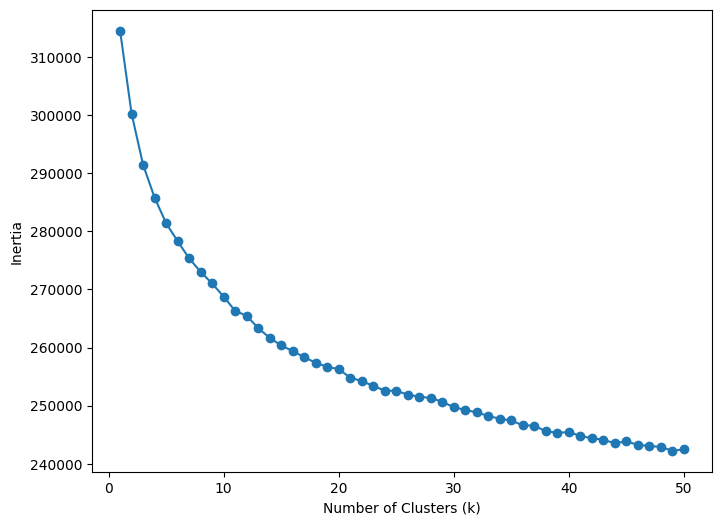

In [35]:
def elbow_method(data, max_k):
    inertias = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)
    
    plt.figure(figsize=(8, 6))
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.plot(range(1, max_k + 1), inertias, marker="o")
    plt.show()

elbow_method(doc_embeddings, 50)

In [ ]:
num_clusters = 25
kmeans = KMeans(n_clusters=num_clusters)
df["cluster"] = kmeans.fit_predict(doc_embeddings)

group_by_cluster_25 = df.copy().groupby("cluster")

samples_clusters_25 = group_by_cluster_25.apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))
samples_clusters_25 = samples_clusters_25.reset_index(drop=True)
samples_clusters_25.to_csv("clustered_data_25.csv")

/tmp/ipykernel_9819/818348610.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples_clusters_21 = group_by_cluster_21.apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))


# Manually labeling data

In [6]:
class TOPIC(enum.Enum):
    ACADEMICS = 1
    CAREER = 2
    FAMILY = 3
    FINANCES = 4
    HEALTH = 5
    RELATIONS = 6
    OTHER = 7
    NONE = 8


In [7]:
clusters_25 = {0: [TOPIC.FINANCES, TOPIC.FAMILY, TOPIC.ACADEMICS, TOPIC.CAREER],
               1: [TOPIC.FAMILY, TOPIC.RELATIONS, TOPIC.CAREER, TOPIC.FINANCES],
               2: [TOPIC.CAREER, TOPIC.HEALTH, TOPIC.RELATIONS, TOPIC.FAMILY],
               3: [TOPIC.ACADEMICS, TOPIC.CAREER],
               4: [TOPIC.FAMILY, TOPIC.FINANCES, TOPIC.HEALTH],
               5: [TOPIC.CAREER, TOPIC.RELATIONS],
               6: [TOPIC.NONE],  #Surveys
               7: [TOPIC.FAMILY, TOPIC.OTHER], #racism/sexism
               8: [TOPIC.RELATIONS, TOPIC.CAREER, TOPIC.FINANCES],
               9: [TOPIC.RELATIONS, TOPIC.OTHER], #appearance/bullying
               10: [TOPIC.FAMILY, TOPIC.RELATIONS, TOPIC.HEALTH],
               11: [TOPIC.RELATIONS, TOPIC.HEALTH],
               12: [TOPIC.OTHER], #Suicide
               13: [TOPIC.ACADEMICS, TOPIC.HEALTH],
               14: [TOPIC.RELATIONS, TOPIC.FAMILY, TOPIC.OTHER], #drugs
               15: [TOPIC.FINANCES, TOPIC.FAMILY],
               16: [TOPIC.RELATIONS, TOPIC.HEALTH],
               17: [TOPIC.FAMILY, TOPIC.RELATIONS, TOPIC.FINANCES],
               18: [TOPIC.CAREER, TOPIC.HEALTH, TOPIC.ACADEMICS, TOPIC.FAMILY, TOPIC.RELATIONS],
               19: [TOPIC.FINANCES, TOPIC.ACADEMICS, TOPIC.OTHER, TOPIC.RELATIONS], #Motivation
               20: [TOPIC.RELATIONS, TOPIC.OTHER], #Mindset
               21: [TOPIC.RELATIONS, TOPIC.OTHER], #Social incidents
               22: [TOPIC.FAMILY, TOPIC.HEALTH, TOPIC.ACADEMICS],
               23: [TOPIC.RELATIONS, TOPIC.OTHER], #Social incidents
               24: [TOPIC.FAMILY, TOPIC.RELATIONS, TOPIC.ACADEMICS, TOPIC.HEALTH]}

In [9]:
df = pd.read_csv("25_cluster_data.csv")

df["topics"] = df["cluster"].map(clusters_25)

df["topic_count"] = df["topics"].apply(lambda topics: Counter(topics))

posts_with_family = df[df['topics'].apply(lambda x: TOPIC.FAMILY in x)]
posts_with_finance = df[df['topics'].apply(lambda x: TOPIC.FINANCES in x)]
posts_with_career = df[df['topics'].apply(lambda x: TOPIC.CAREER in x)]

ids_with_family = posts_with_family['id'].tolist()
ids_with_finance = posts_with_finance['id'].tolist()
ids_with_career = posts_with_career['id'].tolist()

overlap = list(set(ids_with_family) & set(ids_with_finance))

print(len(overlap))
total_count = sum(df["topic_count"], Counter())

total_count_df = pd.DataFrame(total_count.items(), columns=["Topic", "Count"]).sort_values(by="Count", ascending=False)

total_count_df["Percentage"] = (total_count_df["Count"] / len(df)) * 100

1542


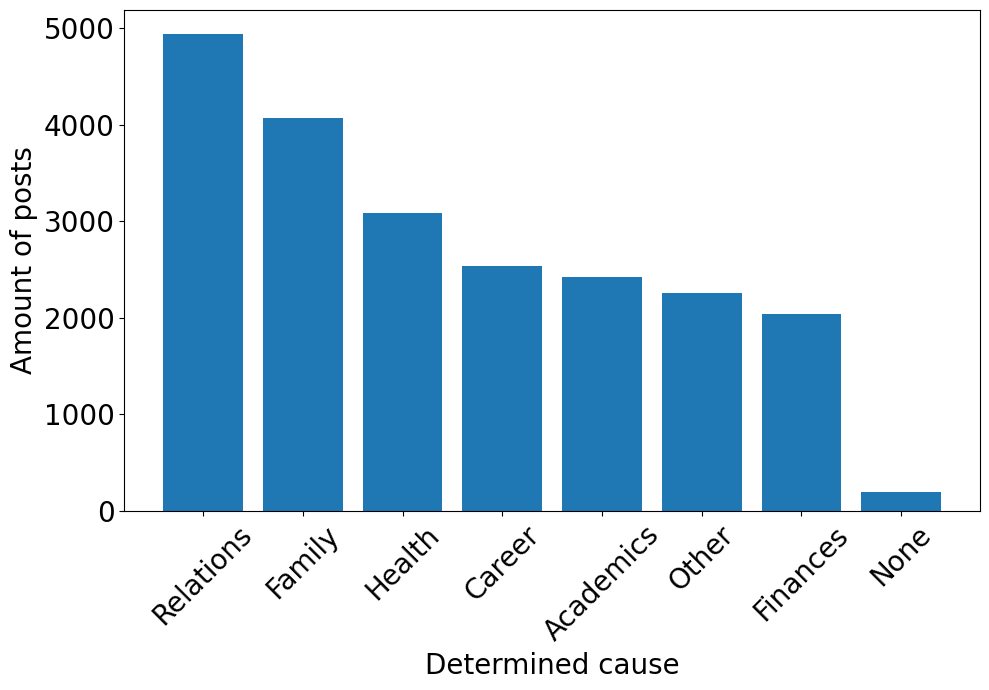

In [3]:
#Generate graph
results = {"Relations": 4939,
           "Family": 4071,
           "Health": 3088,
           "Career": 2533,
           "Academics": 2424,
           "Other": 2259,
           "Finances": 2034,
           "None": 196}

sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 7))
plt.bar(sorted_results.keys(), sorted_results.values())

plt.xlabel("Determined cause", fontsize=20)  
plt.ylabel("Amount of posts", fontsize=20)
plt.xticks(rotation=45, fontsize = 20)
plt.yticks(fontsize = 20)
plt.tight_layout()
plt.show()
